In [2]:
import pandas as pd

In [36]:
# Replace the path with your actual file location
file_path = '/content/drive/MyDrive/GenEd-official/Applied ML/16-july-Applied-ML/WildBlueberryPollinationSimulationData.csv'
df = pd.read_csv(file_path)

# Preview the data
df.head()


,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle


In [37]:
df = df.drop(columns=['Row#'])

X = df.drop(columns=['yield'])
y = df['yield']

In [38]:
# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# 3. ColumnTransformer (All columns are numeric here)
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())                  # Scale
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features)
])

In [40]:
# 4. Full Pipeline
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [41]:
from sklearn import set_config
set_config(display='diagram')

In [42]:
model_pipeline.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['clonesize', 'honeybee', 'bumbles', 'andrena',
                                   'osmia', 'MaxOfUpperTRange',
                                   'MinOfUpperTRange', 'AverageOfUpperTRange',
                                   'MaxOfLowerTRange', 'MinOfLowerTRange',
                                   'AverageOfLowerTRange', 'RainingDays',
                                   'AverageRainingDays', 'fruitset', 'fruitmass',
                                   'seeds'])]),
 'feature_selection': SelectKBest(score_func=<function f_regression at 0x7f53687f7100>),
 'regressor': RandomForestRegressor(random_state=42)}

In [43]:
# 5. Hyperparameter Tuning
param_grid = {
    'feature_selection__k': [5, 10, 'all'],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['clonesize',
                                                                          'honeybee',
                                                                          'bumbles',
                                                                          'andrena',
                                                                          'osmia',
                                                                          'MaxOfUpperTRange',
                                                                          'MinOfUpperTRange',
                                                                          'AverageOfUpperTRange',
                                                                          'MaxOfLowerTRange',
                                                                          'MinOfLowerTRange',
                                                                          'AverageOfLowerTRange',
                                                                          'RainingDays',
                                                                          'AverageRainingDays',
                                                                          'fruitset',
                                                                          'fruitmass',
                                                                          'seeds'])])),
                                       ('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x7f53687f7100>)),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [5, 10, 'all'],
                         'regressor__max_depth': [None, 5, 10],
                         'regressor__n_estimators': [100, 200]},
             scoring='r2')

In [44]:
# 6. Evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# 7. Save final pipeline with pickle
with open('final_model_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Best Params: {'feature_selection__k': 'all', 'regressor__max_depth': 10, 'regressor__n_estimators': 200}
R2 Score: 0.9881692386150994
MSE: 22994.595710328347


In [45]:
import pickle
# 1. Load the saved pipeline
with open('final_model_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# 2. Load or create new data for prediction
# Example: using the same dataset's first 5 rows (without 'yield')
X_new = df.drop(columns=['yield']).iloc[:5]  # Example data

# 3. Make prediction
predictions = loaded_pipeline.predict(X_new)

# 4. Show result
print("Predictions:", predictions)




Predictions: [4022.73641517 4931.57262277 3954.90615067 4236.51367247 3479.10424124]


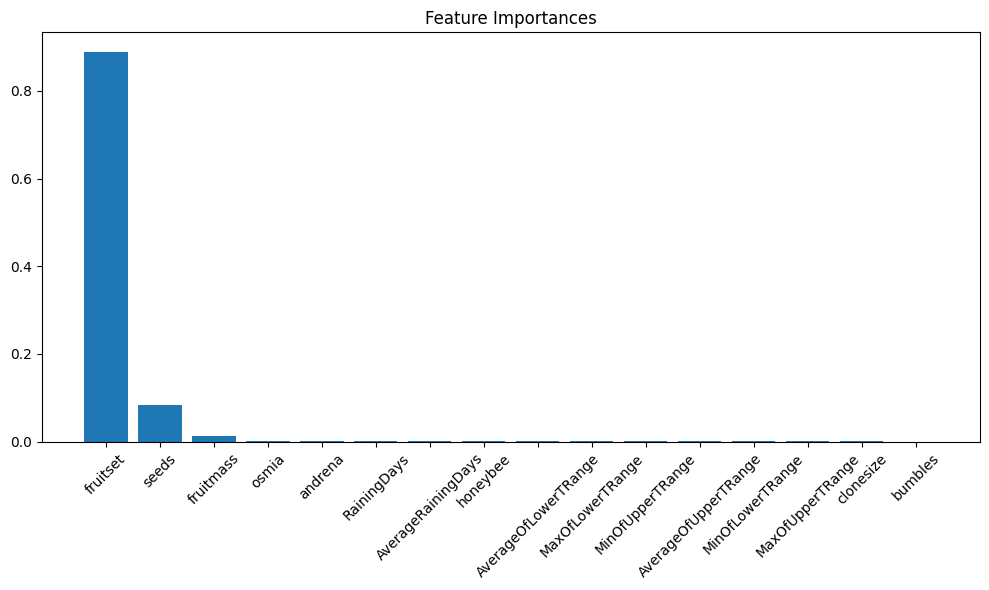

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names after selection
selected_features_mask = best_model.named_steps['feature_selection'].get_support()
selected_features = X.columns[selected_features_mask]

# Get importances from the model
importances = best_model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), selected_features[indices], rotation=45)
plt.tight_layout()
plt.show()


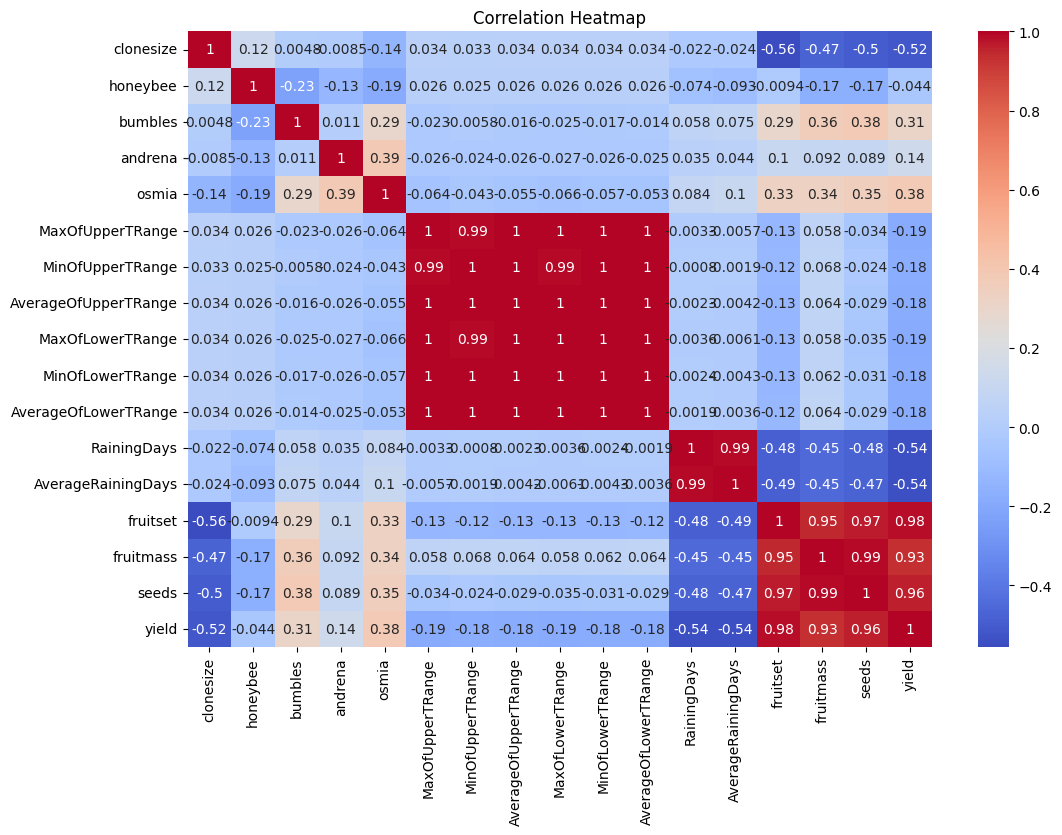

In [47]:
# Compute correlation
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
